# Análise Exploratória dos Dados do IMDB

Neste Mini-Projeto foi feito uma análise exploratória de dados usando Linguagem Python, Linguagem SQL e Banco de Dados SQLite. 

Foram utilizados dados reais do IMDB disponíveis publicamente.

O objetivo dessa Análise Exploratória de Dados é responder as seguintes perguntas:

  1. Quais São as Categorias de Títulos Mais Comuns no IMDB?
  2. Qual o Número de Títulos Por Gênero?
  3. Qual a Mediana de Avaliação dos Filmes Por Gênero?
  4. Qual a Mediana de Avaliação dos Filmes Em Relação ao Ano de Estréia?
  5. Qual o Número de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia?
  6. Qual o Filme Com Maior Tempo de Duração? Calcule os Percentis.
  7. Qual a Relação Entre Duração e Gênero?
  8. Qual o Número de Filmes Produzidos Por País?
  9. Quais São os Top 10 Melhores Filmes?
  10. Quais São os Top 10 Piores Filmes?

## Instalando e Carregando Pacotes

In [ ]:
# Instala o pacote que permite pegar as bases do IMDB em banco SQLite
# https://pypi.org/project/imdb-sqlite/
%pip install -q imdb-sqlite

In [ ]:
# Instala o pacote que permite pegar os bancos de dados da ISO de países, subdivisões, língua, moeda e definições e traduções de scripts
# https://pypi.org/project/pycountry/
%pip install -q pycountry

In [3]:
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

## Carregando os Dados

In [4]:
%%time
!imdb-sqlite

2022-02-21 16:20:19,521 DB already exists: (imdb.db). Refusing to modify. Exiting
CPU times: user 24.1 ms, sys: 1.48 ms, total: 25.6 ms
Wall time: 260 ms


In [5]:
conn = sqlite3.connect("imdb.db")

In [6]:
# Cria um dataframe com os nomes das tabelas do imdb.db
tables = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type = 'table'", conn)

In [7]:
print("Quatidade de tabelas: ", len(tables))
tables

Quatidade de tabelas:  6


,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes
5,ratings


In [8]:
# Converte o objeto de um dataframe para uma lista
tables = tables["Table_Name"].values.tolist()

In [9]:
# Mostra o esquema de cada tabela
for table in tables:
  query = "PRAGMA TABLE_INFO({})".format(table)
  res = pd.read_sql_query(query, conn)
  print("Esquema da tabela:", table)
  display(res)
  print("-" * 100)
  print("\n")

Esquema da tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




## Análise Exploratória

### 1 - Quais São as Categorias de Títulos Mais Comuns no IMDB?

In [44]:
# Conta a quantidade de vezes que cada categoria aparece na tabela titles
query1 = '''SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type'''
res1 = pd.read_sql_query(query1, conn)
display(res1)

,type,COUNT
0,movie,602608
1,short,856897
2,tvEpisode,6518779
3,tvMiniSeries,42195
4,tvMovie,135036
5,tvPilot,2
6,tvSeries,221441
7,tvShort,10457
8,tvSpecial,36012
9,video,257613


In [45]:
# Cria uma coluna "percentual" para facilitar a visualização dos dados
res1["percentual"] = (res1["COUNT"] / sum(res1["COUNT"])) * 100
display(res1)

,type,COUNT,percentual
0,movie,602608,6.917370
1,short,856897,9.836367
2,tvEpisode,6518779,74.829418
3,tvMiniSeries,42195,0.484359
4,tvMovie,135036,1.550086
5,tvPilot,2,0.000023
6,tvSeries,221441,2.541933
7,tvShort,10457,0.120036
8,tvSpecial,36012,0.413384
9,video,257613,2.957154


#### Gráfico com as 3 categorias mais relevantes mais uma categoria "outros" que engloba os demais tipos

In [46]:
# Cria um dicionário com a contagem e o percentual total das categorias menos relevantes
others = {}
others["COUNT"] = res1[res1["percentual"] < 5]["COUNT"].sum()
others["percentual"] = res1[res1["percentual"] < 5]["percentual"].sum()
others["type"] = "others"

In [47]:
others

{'COUNT': 733235, 'percentual': 8.41684441025727, 'type': 'others'}

In [48]:
# Filtra o dataframe res1
res1 = res1[res1["percentual"] > 5]

In [49]:
# Adiciona a categoria referente a "outros" e ordena o dataframe
res1 = res1.append(others, ignore_index=True)
res1 = res1.sort_values(by = "COUNT", ascending = False)

In [51]:
display(res1)

,type,COUNT,percentual
2,tvEpisode,6518779,74.829418
1,short,856897,9.836367
3,others,733235,8.416844
0,movie,602608,6.917370


In [54]:
# Ajusta as labels
labels = [str(res1["type"][i]) + " [" + str(round(res1["percentual"][i], 2)) + "%]" for i in res1.index]

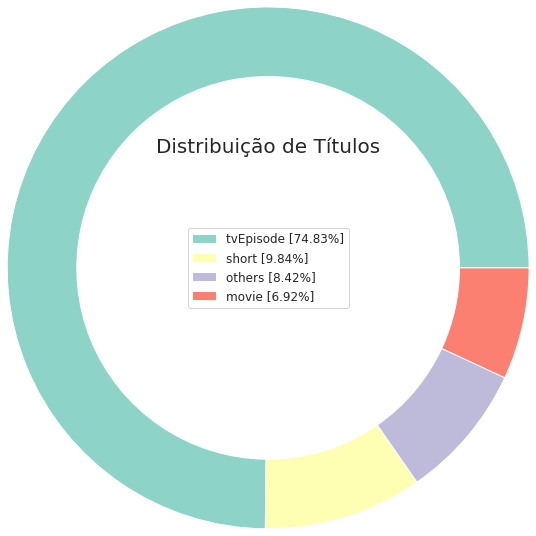

In [55]:
# Plot
cs = cm.Set3(np.arange(100))

fig = plt.figure()

plt.pie(res1["COUNT"], labeldistance=1, radius=3, colors=cs, wedgeprops=dict(width=0.8))
plt.legend(labels=labels, loc="center", prop={"size":12})
plt.title("Distribuição de Títulos", loc="Center", fontdict={"fontsize":20, "fontweight":20})
plt.show()

### 2 - Qual o Número de Títulos Por Gênero?


### 3 - Qual a Mediana de Avaliação dos Filmes Por Gênero?


### 4 - Qual a Mediana de Avaliação dos Filmes Em Relação ao Ano de Estréia?


### 5 - Qual o Número de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia?


### 6 - Qual o Filme Com Maior Tempo de Duração? Calcule os Percentis.


### 7 - Qual a Relação Entre Duração e Gênero?


### 8 - Qual o Número de Filmes Produzidos Por País?


### 9 - Quais São os Top 10 Melhores Filmes?


### 10 - Quais São os Top 10 Piores Filmes?